<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        print("who is q ", q)
        # Formulate problem
        param = cp.Variable(n)
        print("shape param ", param.shape)
        print("dim ", n)
        print(S_inv.shape)
        print("S_inv ", S_inv)
        partial = S_inv @ param  # should be (m * n,)
        if S_inv.shape == (n, n):
          print("S_inv (n, n)")
          param_norm = cp.pnorm(partial, p=q)
        else:  # should be a stack of matrix
          print("S_inv conc")
          print("shape partial 1", partial.shape)
          partial = cp.reshape(partial, (m, n), order='C')
          print("shape partial ", partial.shape)
          param_norm = cp.pnorm(partial, p=q, axis=1)
        print("param_norm.shape", param_norm.shape)
        print("param_norm\n", param_norm)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        print("ciao2")
        abs_error = cp.abs(X @ param - y)
        print("abs_error.shape ", abs_error.shape)
        print("ciao3")
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        print("ciao4")
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False


    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [3]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res ", res)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp



In [5]:
# define observations
np.random.seed(45)
n_observationsss = 300
dim = 10
#cov = np.random.randint(low=1, high=10, size=(d, d))
#cov = np.random.randn(d, d)
#cov = cov.T @ cov + np.eye(dim) * 1e-5
#print(cov)
#print(np.linalg.eigvalsh(cov))
cov = np.eye(dim)
X_orig = np.random.rand(n_observationsss, dim) @ cov
#X_orig = np.random.randint(low=1, high=4, size=(n, d)) * 1.0
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(dim)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n_observationsss, dim))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
n_observationsss = X_orig.shape[0]
print("shape ", X_orig.shape)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
print("end block")

shape  (300, 10)
final shape  (300, 10)
end block


In [ ]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

sd_orig 
 [0.28599382 0.29381609 0.28877894 0.28626491 0.28237674 0.28861653
 0.29327079 0.28411263 0.29596406 0.28574582]
S_inv_orig.shape  (3000, 10)
who is q  1
shape param  (10,)
dim  10
(3000, 10)
S_inv  [[3.49657908 0.         0.         ... 0.         0.         0.        ]
 [0.         3.40348959 0.         ... 0.         0.         0.        ]
 [0.         0.         3.4628564  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 3.51973093 0.         0.        ]
 [0.         0.         0.         ... 0.         3.37878864 0.        ]
 [0.         0.         0.         ... 0.         0.         3.49961373]]
S_inv conc
shape partial 1 (3000,)
shape partial  (300, 10)
param_norm.shape (300,)
param_norm
 norm1(reshape([[3.50 0.00 ... 0.00 0.00]
 [0.00 3.40 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 3.38 0.00]
 [0.00 0.00 ... 0.00 3.50]] @ var137, (300, 10), C))
ciao2
abs_error.shape  (300,)
ciao3
ciao4


100%|██████████| 200/200 [00:25<00:00,  7.77it/s]


you are printing coeff in function of l1 norm


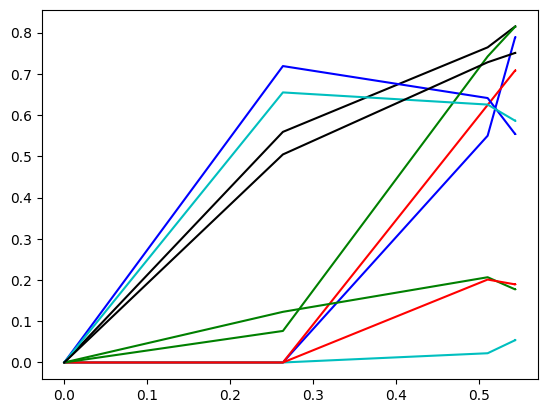

In [9]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
sd_orig = np.std(X_orig, axis=0)
print("sd_orig \n", sd_orig)
S_inv_orig = np.diag(1 / sd_orig)
#S_inv_orig = np.eye(dim)
S_inv_orig = np.array([S_inv_orig] * n_observationsss)
S_inv_orig = np.concatenate(S_inv_orig)
print("S_inv_orig.shape ", S_inv_orig.shape)
test = S_inv_orig @ np.arange(dim)
#print("test mult\n", test)
#print("test reshape \n", test.reshape(n_observationsss, dim, order='C'))
#print(S_inv_orig)
#S_inv_orig = np.diag(1 / sd_orig)
#print("S_inv_orig shape\n ", S_inv_orig.shape)
#S_inv_orig = np.eye(X_orig.shape[0])
linfadvtrain = AdversarialTraining(X_orig, y, S_inv_orig, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf, ax)

test size  0.1111111111111111
nbr component without missing entries  87.0
[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0

100%|██████████| 200/200 [00:04<00:00, 47.40it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas


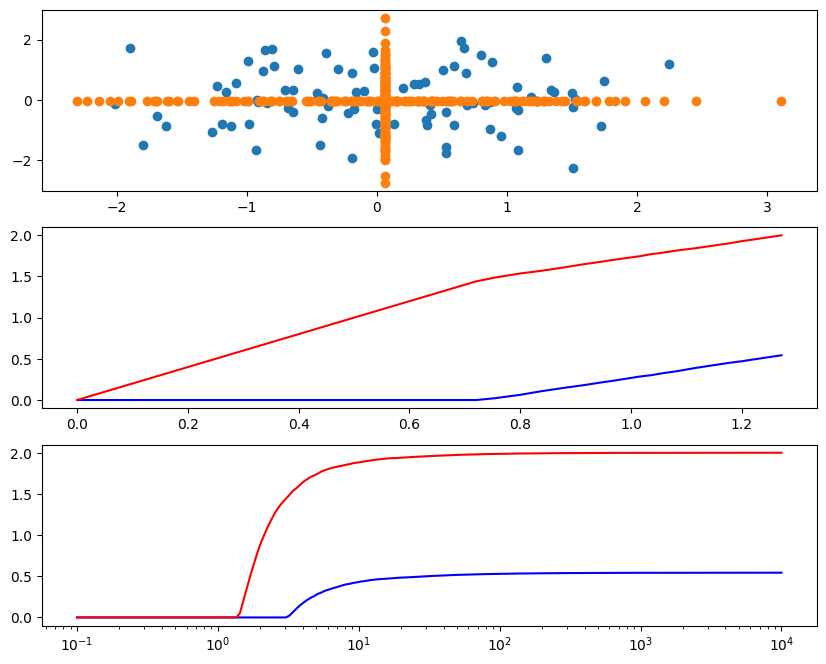

In [69]:
# 2d toy example
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf_2d')


def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    # p_missing = [0.3, 0.3, 0.4]
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

nb_2d_train = 400
nb_2d_test = 50
nb_tot = nb_2d_train + nb_2d_test
ts = nb_2d_test / nb_tot
print("test size ", ts)
beta_2d = np.array([0.5, 2])
p_miss_2d = [0.2, 0.4, 0.4]
mask_2d = generate_masks_2d(nb_2d_train, p_miss_2d)
M = np.sum(mask_2d, axis=1)
print("nbr component without missing entries ", np.sum(1-M))
#print(mask_2d)
print(M)
X_complete_2d = np.random.randn(nb_2d_train + nb_2d_test, 2)
y_complete_2d = X_complete_2d @ beta_2d + np.random.randn(nb_tot) * 1e-1

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_complete_2d, y_complete_2d, test_size=ts, random_state=42)

X_2d_masked = X_train_2d * mask_2d

X_nan_train_2d = X_train_2d.copy()
X_nan_train_2d[mask_2d == 1] = np.nan
#print(X_nan_2d)
X_br_train_2d = single_imputation(X_nan_train_2d, BayesianRidge())
ax[0].scatter(X_br_train_2d[M == 0, 0], X_br_train_2d[M == 0, 1])
ax[0].scatter(X_br_train_2d[M == 1, 0], X_br_train_2d[M == 1, 1])
S_inv_2d = np.eye(2)

linfadvtrain_2d = AdversarialTraining(X_br_train_2d, y_train_2d, S_inv_2d, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain_2d(adv_radius=a)
alphas_adv, coefs_advtrain_linf_2d  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_2d, ax[1])
plot_coefs(alphas_adv, coefs_advtrain_linf_2d, ax[2])

#print("coef ", coefs_advtrain_linf_2d)





In [ ]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


In [ ]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

In [ ]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


In [ ]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)


In [ ]:
# mi bayesian ridge

number_multiple_imputed_datasets = 5
X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)

fig, ax = plt.subplots(num='advtrain_linf_mi')
linfadvtrain_mi = AdversarialTraining(X_mi, yy, S_inv_mi, p=np.inf)
estimator_mi = lambda X, y, a:  linfadvtrain_mi(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mi  = get_path(X_mi, yy, estimator_mi, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mi, ax)





In [ ]:
Observations:

-) If the data are np.random.randn(), all the graphs looks similar
-) very caotic results if we multiply by a cov matrix


end block


In [ ]:
x = np.random.randint(1, 10, size=10)
print(x)
print(np.reshape(x, (2, 5), order='C'))

[7 4 1 5 3 8 5 7 3 8]
[[7 4 1 5 3]
 [8 5 7 3 8]]
